# **COMP 433 Implementation Questions**

**Name:** Mohammed Mutassem

**Student ID:** 40169940

In [ ]:
!git clone https://github.com/momutassem/a3-comp-433.git
%cd /content/a3-comp-433/
!pip install -r requirements.txt

%cd /content/a3-comp-433/data 
!gdown https://drive.google.com/uc?id=1kz18SjeocJ0Im0j938X_g7xCVf-4v1M8
!unzip archive.zip
!rm archive.zip
% /content/a3/comp-433/

In [2]:
#%pip install -r requirements.txt
import warnings
import os

from experiments import run_experiment
from utils.general import load_config
from utils.plot import plot_batch_accs, plot_confusion_matrix, plot_training_loss, plot_predictions
from models.ResNet18 import ResNet18

warnings.filterwarnings("ignore", category=UserWarning)

CNN_CONFIG_PATH = os.path.join(os.getcwd(), "models", "CNN.yaml")
LSTM_CONFIG_PATH = os.path.join(os.getcwd(), "models", "LSTM.yaml")
FINGERS_DATA = 'fingers'
CLIMATE_DATA = 'climate'

## **Question 1**

#### **Architecture Design**
The designed CNN model is structured with a convolutional module and a dense module:

**Convolutional Module**

The convolutional module progressively transforms the input images to extract the important features from the input images. The module consists of **three layers**, each followed by **batch normalization** and **ReLU activation**. Batch normalization normalizes the intermediate feature maps to stabilize the training and reduce the rsik of vanishing or exploding gradients. It also accelerates the convergence. The **kernel sizes [5, 7, 9]** are chosen to progressively increase the receptive field across layers. Even though only three layers are used since this is a simple task, the idea was to make the early layers capture the local details, while the deeper layers capture the more abstract patterns. The initial **output channels** are set to **4** to keep the model lightweight at the start, and they are increased by a **factor of 1.5** after each layer to allow the network to learn more abstract representations. **Padding** is set as kernel_size // 2 to preserve spatial dimensions across layers, and a **stride of 1** is used to capture as much spatial information as possible. Finally, the weights are initialized using **Xavier initialization** to accelerate convergence.

**Dense Module**

The dense module takes the feature maps extracted by the convolutional module and maps them to the final class probabilities. First, the feature maps are **flattened** into a 1D vector. Then, a **single dense layer** maps these features to the six output neurons. The output layer applies a **LogSoftmax activation** to convert the raw scores into log probabilities for each class. 

#### **Chosen Hyperparameters**

**Data Preprocessing / Augmentations**

The images are first **reshaped (128x128)** to a fixed sise to make sure all the samples are the same shape. I then **normalize** the pixels to ensure the model is not affected by their actual values, and instead focus on capturing the abstraction of the geometry in the images. For the augmentations, I employ **horizontal flipping (p=0.5)**, because the images contain both left and right hands. This allows the model to learn to recognize the number of fingers regardless of the hand orientation. I also employ a small **rotation(+/- 15 degrees)** to help the model handle slight variations in the hand positions. These augmenations are only used on the training set.

**Training Hyperparameters**

The model was trained for **5 epochs**, since the task is simple and the number of training samples are relatively small. In my case, training for longer would not have any benefit since the model already performs well, and it would risk overfitting. A smaller **learning rate (0.0005)** was selected so that the model learns gradually (more stable) without overshooting minimas. I found that a **batch size of 256** was a good balance between reducing the noise in the gradient updates, and not being too computationally expensive. The **Adam optimizer** was used since it employs momentum and adaptive learning rates, though the model also performed well using SGD. The **Categorical Cross Entropy** was used as the loss function, since this is a multi-class problem. Finally, I used a **20% validation split**.


In [3]:
# Loads all the configurations/parameters to be used
fingers_config = load_config(CNN_CONFIG_PATH, dataset='fingers')

# Initialize model
cnn = fingers_config["model"]
cnn._initialize_weights()

# Train, validate, and evaluate model
metrics = run_experiment(cnn, fingers_config)

/Users/mohammed/Code/comp433/assignments/a3/data/fingers
Seeds set to: 42
Using device: mps


Experiment Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1/5] Train Loss: 1.9484, Train Acc: 83.03% | Val Loss: 0.0377, Val Acc: 98.61%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 2/5] Train Loss: 0.0168, Train Acc: 99.41% | Val Loss: 0.0083, Val Acc: 99.72%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 3/5] Train Loss: 0.0057, Train Acc: 99.88% | Val Loss: 0.0033, Val Acc: 99.92%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 4/5] Train Loss: 0.0034, Train Acc: 99.92% | Val Loss: 0.0040, Val Acc: 99.89%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 5/5] Train Loss: 0.0029, Train Acc: 99.94% | Val Loss: 0.0017, Val Acc: 99.97%


Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

#### **Training & Validation Performance**

The training batch accuracy starts low but rapidly increases and stabilizes near 100% by the 200th iteration. In contrast, the validation batch accuracy begins significantly higher (around 97%) and fluctuates up to the 20th iteration. The reason for the higher validation set accuracy could be that the training samples are more challenging to learn early on due to the different augmentations used. Despite the fluctuating curve, the actual magnitude of these fluctuations is small (about 2% max). Overall, the model appears to be learning almost perfectly.

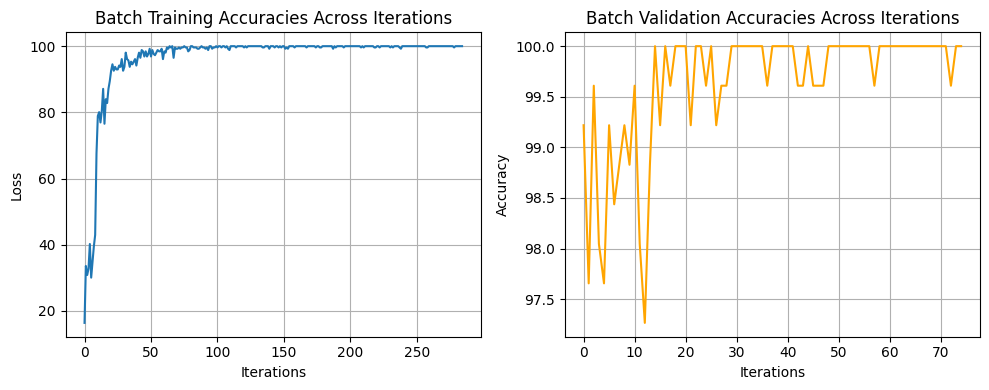

In [4]:
plot_batch_accs(metrics["train"]["batch_accs"], metrics["val"]["batch_accs"])

#### **Testing Performance**
The classification scores on the test set show perfect scores, with precision, recall, and F1-scores all at 1.00 for every class. The confusion matrix also shows that, where only two images 0f 4 fingers were misclassified as 3 fingers. The overall test accuracy is 100%, which shows that the model generalizes very well on the data. 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600

[[600   0   0   0   0   0]
 [  0 600   0   0   0   0]
 [  0   0 600   0   0   0]
 [  0   0   0 600   0   0]
 [  0   0   0   2 598   0]
 [  0   0   0   0   0 600]]


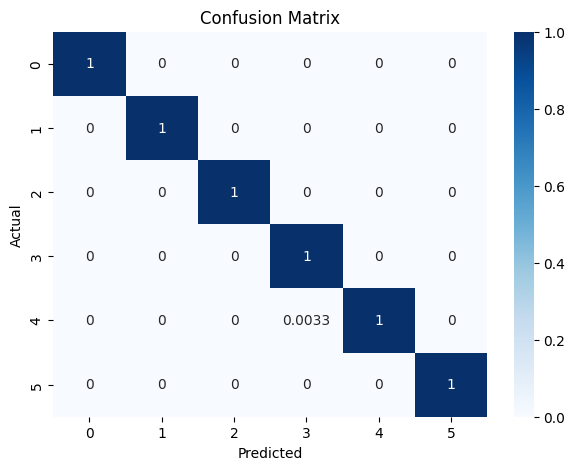

In [5]:
print(metrics['test']['scores']['report'])
print(metrics['test']['scores']['cm'])
plot_confusion_matrix(metrics["test"]["scores"]["cm"])

## **Question 2**

In [6]:
# Initialize model
resnet = ResNet18(fingers_config)

# Train, validate, and evaluate model
resnet_metrics = run_experiment(resnet, fingers_config)

Experiment Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1/5] Train Loss: 0.0964, Train Acc: 97.10% | Val Loss: 0.0203, Val Acc: 99.53%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 2/5] Train Loss: 0.0006, Train Acc: 99.99% | Val Loss: 0.0002, Val Acc: 100.00%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 3/5] Train Loss: 0.0002, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 4/5] Train Loss: 0.0001, Train Acc: 100.00% | Val Loss: 0.0001, Val Acc: 100.00%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 5/5] Train Loss: 0.0001, Train Acc: 100.00% | Val Loss: 0.0000, Val Acc: 100.00%


Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

#### **Performance Comparison**

The ResNet18 architecure trained from scratch achieves practically the same performance as the custom CNN architecture. Both models achieve **100% accuracy** on the test set, with perfect precision, recall, and F1-scores across all classes. However, there are very minor differences between both architectures. Firstly, Resnet achieves 0 misclassifications compared to the 2 misclassifications of the CNN. This is negligeable but there is not much else to say about the difference in their testing results. Secondly, ResNet's training accuracy curve **stabilizes almost instantly** compared to the CNN, and **barely shows any fluctuations**. Its batch validation accuracy curve exhibits the same fluctuation pattern in the first 15 iterations as the CNN, but with a slightly smaller magnitude (<1% compared to 2%). However, as oposed to to the CNN, the curve shows no fluctuations whatsoever after 15 iterations. 

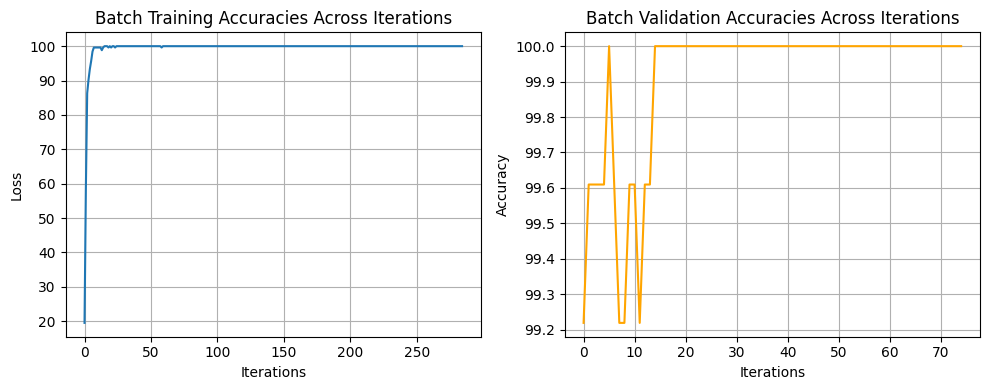

In [7]:
plot_batch_accs(
    resnet_metrics["train"]["batch_accs"], resnet_metrics["val"]["batch_accs"]
)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       1.00      1.00      1.00       600
           2       1.00      1.00      1.00       600
           3       1.00      1.00      1.00       600
           4       1.00      1.00      1.00       600
           5       1.00      1.00      1.00       600

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



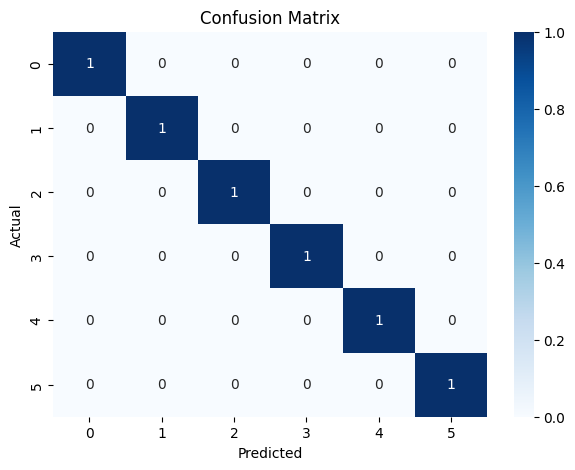

In [8]:
print(resnet_metrics['test']['scores']['report'])
plot_confusion_matrix(resnet_metrics["test"]["scores"]["cm"])

## **Question 3**
Since the question does not specify wether to freeze the backbone or finetune it, I assumed we are asked to freeze the early layers as that is typically what is done with transfer learning.

In [9]:
# Initialize model
resnet_pretrained = ResNet18(fingers_config, pre_trained=True, freeze_backbone=True)

# Train, validate, and evaluate model
resnet_pretrained_metrics = run_experiment(resnet_pretrained, fingers_config)

Experiment Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 1/5] Train Loss: 1.1092, Train Acc: 65.17% | Val Loss: 0.9640, Val Acc: 71.06%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 2/5] Train Loss: 0.5080, Train Acc: 89.34% | Val Loss: 0.3987, Val Acc: 92.44%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 3/5] Train Loss: 0.3608, Train Acc: 92.63% | Val Loss: 0.3131, Val Acc: 92.78%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 4/5] Train Loss: 0.2964, Train Acc: 93.83% | Val Loss: 0.2654, Val Acc: 94.00%


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Validation:   0%|          | 0/15 [00:00<?, ?it/s]

[Epoch 5/5] Train Loss: 0.2485, Train Acc: 94.47% | Val Loss: 0.2301, Val Acc: 94.83%


Evaluation:   0%|          | 0/15 [00:00<?, ?it/s]

#### **Training & Validation Performance**
The batch training accuracies are slower to stabilize and exhibits more fluctuations compared to the previous models. Furthermore, the magnitude of these fluctuations is a lot higher. The validation accuracy is initially around 70%, which is considerable less than the 2 previous models' starting validatin accuracy. Furthermroe, it fluctuates significantly in the first 20 iterations, a pattern exhibited by both previous models, though at much lower magnitudes. Nevertheless, it begins to stabilize around 94-95% after 20 or so iteration and shows slight increases afterward. The accuracy could perhaps increase if we trained for more epochs.

Overall, the model achieves excellent results but perfroms slighlty worse than the two previous ones. This is expected since we are not training the backbone, which limits the model from extracting the specific features of the images. 

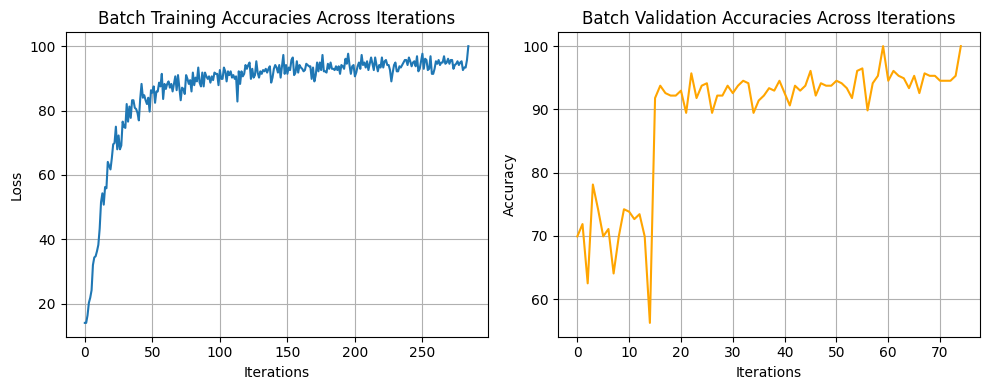

In [10]:
plot_batch_accs(
    resnet_pretrained_metrics["train"]["batch_accs"],
    resnet_pretrained_metrics["val"]["batch_accs"],
)

#### **Testing Performance**
ResNet18 with transfer learning achieves **94% accuracy**, which is lower than both the CNN and ResNet18 trained from scratch but still shows a very strong performance overall. The model handles most classes well but struggles a little with 2 and 3 finger images, with 89% and 82% recall, respectively. Though still very good, it is 10% less compared to the previous 2 models. These misclassifications are shown in the confusion matrix, with **200 total errors** (55 three finger images were misclassified as 4 fingers, 47 two and three finger images were misclassified as a one and two fingers respectively) compared to only 2 for the custom CNN and 0 for ResNet18 trained from scratch.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       600
           1       0.92      0.97      0.94       600
           2       0.89      0.89      0.89       600
           3       0.98      0.82      0.89       600
           4       0.90      0.99      0.94       600
           5       1.00      1.00      1.00       600

    accuracy                           0.94      3600
   macro avg       0.95      0.94      0.94      3600
weighted avg       0.95      0.94      0.94      3600

[[597   3   0   0   0   0]
 [  3 581  16   0   0   0]
 [  0  47 531  11  11   0]
 [  0   3  47 495  55   0]
 [  0   0   3   1 596   0]
 [  0   0   0   0   0 600]]


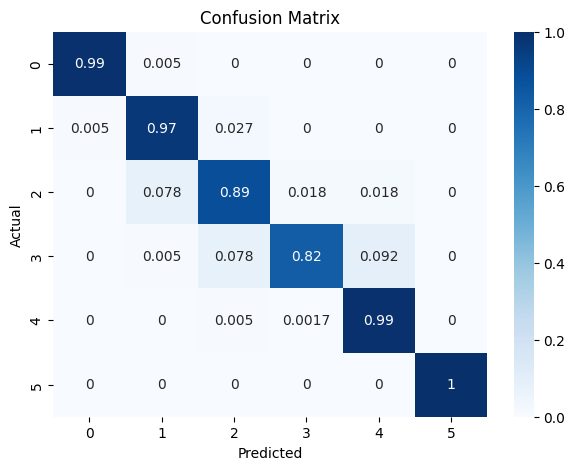

In [11]:
print(resnet_pretrained_metrics['test']['scores']['report'])
print(resnet_pretrained_metrics['test']['scores']['cm'])
plot_confusion_matrix(resnet_pretrained_metrics["test"]["scores"]["cm"])

## **Question 4**

In [12]:
# Loads all the configurations/parameters to be used
climate_config = load_config(LSTM_CONFIG_PATH, 'climate')

# Initialize model
lstm = climate_config['model']

# Train, validate, and evaluate model
lstm_metrics = run_experiment(lstm, climate_config, validate_experiment=False,display_logs=False)

/Users/mohammed/Code/comp433/assignments/a3/data/climate
Seeds set to: 42


Experiment Progress:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

Training:   0%|          | 0/46 [00:00<?, ?it/s]

#### **Training Loss Analysis**

The training loss starts off with a relatively low value, and sharply declines within the first epoch, it then quickly continues to stabilize and plateau at a low value, which indicates that the model is able to capture the temporal patterns from the training data.

Test loss:  tensor(0.0048) Final train loss:  0.002457884568012441


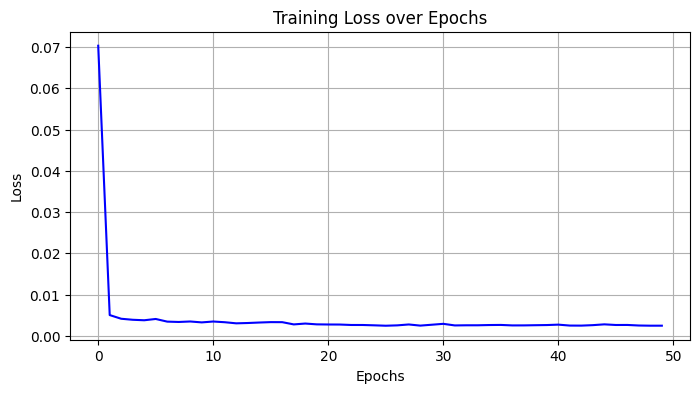

In [13]:
print('Test loss: ', lstm_metrics['test']['loss'], 'Final train loss: ', lstm_metrics['train']['loss'][-1])
plot_training_loss(lstm_metrics['train']['loss'])

#### **Original vs Predicted Data Analysis**

The plot of the original data points vs the predicted data points shows that the mdoel captures the overall trends in the data accurately. However, whenever there are **sudden peaks** in the temperature, the predicted points are **slightly less** than the original. Furthermore, there is a **slight delay** between the predicted and the orignal temperatures following sudden decreases in temperatures.

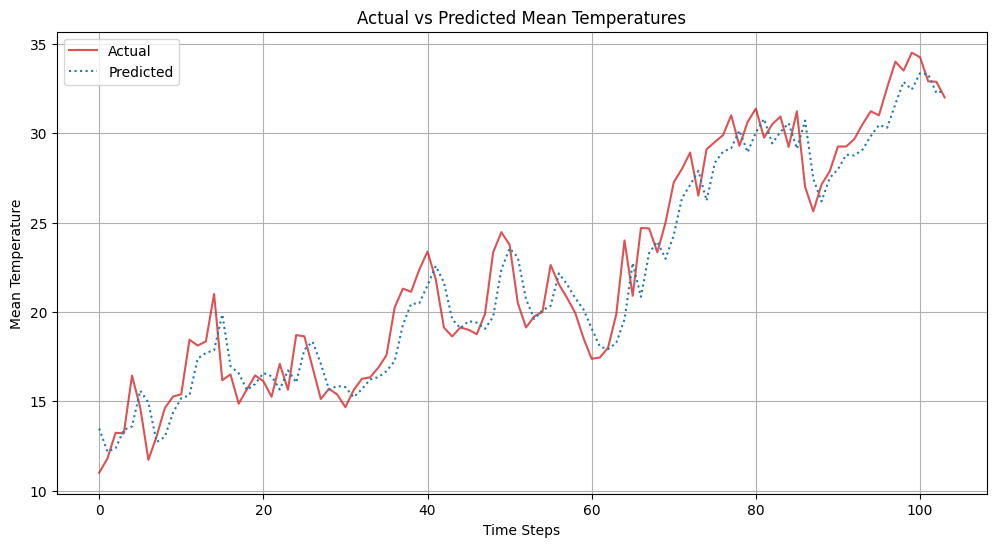

In [14]:
plot_predictions(lstm_metrics['test']['labels'], lstm_metrics['test']['predictions'], climate_config['scaler'])